In [1]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models
from matplotlib import pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Load Data

In [12]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229, 0.224, 0.225])
])

In [13]:
dataset_path = './dataset'

dataset = datasets.ImageFolder(root=dataset_path, transform=image_transforms)
len(dataset)

2300

In [14]:
dataset.classes

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [15]:
num_classes = len(dataset.classes)
num_classes

6

In [16]:
train_size = int(0.75 * len(dataset))
val_size = len(dataset) - train_size

train_size, val_size

(1725, 575)

In [17]:
from torch.utils.data import random_split

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [18]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [19]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [20]:
images[0].shape

torch.Size([3, 224, 224])

In [23]:
images[0].permute(1,2,0).shape

torch.Size([224, 224, 3])

In [21]:
labels[0]

tensor(0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


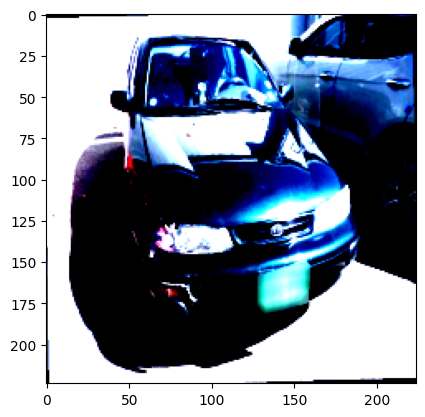

In [28]:
plt.imshow(images[0].permute(1,2,0))
plt.show()

### Model 1: CNN

In [29]:
class CarClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3), stride=1, padding=1), # in:( 3, 224, 224), out: (16, 224, 224)
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),   # out: (16, 112, 112)

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride=1, padding=1), # out (32, 112, 112)
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # out: (32, 56, 56)

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=1, padding=1), # out (64, 56, 56)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # out: (64, 28, 28)

            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.network(x)
        return x

In [30]:
model = CarClassifierCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [31]:
def train_model(model, criterion, optimizer, epochs=5):
    start = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            if (batch_num + 1) % 10 == 0:
                print(f"Batch: {batch_num + 1}, Epoch: {epoch + 1}, Loss: {loss.item():.2f}")

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1} / {epochs}], Avg Loss: {epoch_loss:.4f}")

        # Validation
        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []


        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
            
            print(f"*** Validation Accuracy: {100 * correct/total:.2f}% ***")

    end = time.time()
    print(f"Execution time: {end - start} seconds")
    
    return all_labels, all_predictions            


In [33]:
all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=5)

Batch: 10, Epoch: 1, Loss: 1.40
Batch: 20, Epoch: 1, Loss: 1.56
Batch: 30, Epoch: 1, Loss: 1.34
Batch: 40, Epoch: 1, Loss: 1.56
Batch: 50, Epoch: 1, Loss: 1.43
Epoch [1 / 5], Avg Loss: 1.3899
*** Validation Accuracy: 47.65% ***
Batch: 10, Epoch: 2, Loss: 1.46
Batch: 20, Epoch: 2, Loss: 1.35
Batch: 30, Epoch: 2, Loss: 1.25
Batch: 40, Epoch: 2, Loss: 1.21
Batch: 50, Epoch: 2, Loss: 1.50
Epoch [2 / 5], Avg Loss: 1.2376
*** Validation Accuracy: 51.48% ***
Batch: 10, Epoch: 3, Loss: 1.55
Batch: 20, Epoch: 3, Loss: 0.95
Batch: 30, Epoch: 3, Loss: 1.13
Batch: 40, Epoch: 3, Loss: 1.32
Batch: 50, Epoch: 3, Loss: 1.19
Epoch [3 / 5], Avg Loss: 1.1196
*** Validation Accuracy: 52.17% ***
Batch: 10, Epoch: 4, Loss: 1.13
Batch: 20, Epoch: 4, Loss: 1.06
Batch: 30, Epoch: 4, Loss: 0.90
Batch: 40, Epoch: 4, Loss: 0.81
Batch: 50, Epoch: 4, Loss: 1.11
Epoch [4 / 5], Avg Loss: 1.0446
*** Validation Accuracy: 49.04% ***
Batch: 10, Epoch: 5, Loss: 1.01
Batch: 20, Epoch: 5, Loss: 0.93
Batch: 30, Epoch: 5, Los

### Model 2: CNN with Regularization

In [34]:
class CarClassifierCNNWithRegularization(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(

            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3), stride=1, padding=1), # in:( 3, 224, 224), out: (16, 224, 224)
            nn.BatchNorm2d(16),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),   # out: (16, 112, 112)

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride=1, padding=1), # out (32, 112, 112)
            nn.BatchNorm2d(32), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # out: (32, 56, 56)

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=1, padding=1), # out (64, 56, 56)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # out: (64, 28, 28)

            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)

        )
    
    def forward(self, x):
        x = self.network(x)
        return x

In [35]:
model = CarClassifierCNNWithRegularization(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 19.88
Batch: 20, Epoch: 1, Loss: 6.08
Batch: 30, Epoch: 1, Loss: 1.74
Batch: 40, Epoch: 1, Loss: 1.66
Batch: 50, Epoch: 1, Loss: 1.60
Epoch [1 / 10], Avg Loss: 7.3316
*** Validation Accuracy: 49.22% ***
Batch: 10, Epoch: 2, Loss: 1.57
Batch: 20, Epoch: 2, Loss: 1.31
Batch: 30, Epoch: 2, Loss: 1.47
Batch: 40, Epoch: 2, Loss: 1.17
Batch: 50, Epoch: 2, Loss: 1.34
Epoch [2 / 10], Avg Loss: 1.3494
*** Validation Accuracy: 51.30% ***
Batch: 10, Epoch: 3, Loss: 1.25
Batch: 20, Epoch: 3, Loss: 1.35
Batch: 30, Epoch: 3, Loss: 1.12
Batch: 40, Epoch: 3, Loss: 1.20
Batch: 50, Epoch: 3, Loss: 1.12
Epoch [3 / 10], Avg Loss: 1.2361
*** Validation Accuracy: 50.26% ***
Batch: 10, Epoch: 4, Loss: 1.27
Batch: 20, Epoch: 4, Loss: 0.94
Batch: 30, Epoch: 4, Loss: 1.07
Batch: 40, Epoch: 4, Loss: 1.55
Batch: 50, Epoch: 4, Loss: 1.13
Epoch [4 / 10], Avg Loss: 1.1595
*** Validation Accuracy: 52.52% ***
Batch: 10, Epoch: 5, Loss: 1.23
Batch: 20, Epoch: 5, Loss: 1.16
Batch: 30, Epoch: 5

([3,
  0,
  4,
  0,
  2,
  0,
  4,
  0,
  5,
  2,
  2,
  4,
  2,
  1,
  1,
  2,
  5,
  3,
  2,
  1,
  5,
  0,
  1,
  2,
  3,
  3,
  0,
  3,
  0,
  4,
  4,
  3,
  1,
  5,
  3,
  2,
  3,
  5,
  3,
  4,
  0,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  2,
  3,
  5,
  2,
  4,
  0,
  2,
  4,
  2,
  1,
  5,
  2,
  1,
  1,
  0,
  3,
  2,
  5,
  4,
  5,
  0,
  0,
  0,
  2,
  2,
  0,
  0,
  2,
  2,
  5,
  5,
  1,
  4,
  2,
  0,
  0,
  3,
  3,
  0,
  0,
  2,
  5,
  4,
  3,
  0,
  5,
  0,
  4,
  5,
  5,
  4,
  4,
  2,
  0,
  0,
  1,
  0,
  4,
  0,
  0,
  1,
  2,
  3,
  1,
  1,
  4,
  4,
  1,
  2,
  1,
  4,
  1,
  1,
  2,
  1,
  4,
  5,
  0,
  0,
  0,
  2,
  4,
  3,
  0,
  5,
  3,
  2,
  0,
  0,
  3,
  2,
  5,
  3,
  2,
  5,
  2,
  2,
  0,
  1,
  2,
  3,
  2,
  0,
  3,
  2,
  0,
  2,
  4,
  2,
  5,
  3,
  4,
  0,
  1,
  5,
  3,
  3,
  1,
  4,
  5,
  3,
  5,
  4,
  4,
  2,
  3,
  2,
  2,
  3,
  3,
  3,
  1,
  1,
  4,
  5,
  2,
  1,
  3,
  1,
  2,
  2,
  0,
  1,
  0,
  3,
  3,
  3,
  1,
  0,
  1,
  2,
  3,


### Model 3: Transfer Learning with EfficientNet

In [39]:
class CarClassifierEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')

        for param in self.model.parameters():
            param.requires_grad = False

        in_features = self.model.classifier[1].in_features

        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [40]:
model = CarClassifierEfficientNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p : p.requires_grad, model.parameters()), lr= 0.001)

train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.66
Batch: 20, Epoch: 1, Loss: 1.59
Batch: 30, Epoch: 1, Loss: 1.26
Batch: 40, Epoch: 1, Loss: 1.23
Batch: 50, Epoch: 1, Loss: 1.31
Epoch [1 / 10], Avg Loss: 1.4747
*** Validation Accuracy: 51.30% ***
Batch: 10, Epoch: 2, Loss: 1.17
Batch: 20, Epoch: 2, Loss: 1.23
Batch: 30, Epoch: 2, Loss: 1.14
Batch: 40, Epoch: 2, Loss: 1.06
Batch: 50, Epoch: 2, Loss: 1.15
Epoch [2 / 10], Avg Loss: 1.1325
*** Validation Accuracy: 58.43% ***
Batch: 10, Epoch: 3, Loss: 0.95
Batch: 20, Epoch: 3, Loss: 0.88
Batch: 30, Epoch: 3, Loss: 1.04
Batch: 40, Epoch: 3, Loss: 0.93
Batch: 50, Epoch: 3, Loss: 1.14
Epoch [3 / 10], Avg Loss: 1.0050
*** Validation Accuracy: 59.83% ***
Batch: 10, Epoch: 4, Loss: 0.93
Batch: 20, Epoch: 4, Loss: 0.85
Batch: 30, Epoch: 4, Loss: 0.95
Batch: 40, Epoch: 4, Loss: 0.92
Batch: 50, Epoch: 4, Loss: 0.75
Epoch [4 / 10], Avg Loss: 0.9389
*** Validation Accuracy: 62.43% ***
Batch: 10, Epoch: 5, Loss: 1.02
Batch: 20, Epoch: 5, Loss: 1.06
Batch: 30, Epoch: 5,

([3,
  0,
  4,
  0,
  2,
  0,
  4,
  0,
  5,
  2,
  2,
  4,
  2,
  1,
  1,
  2,
  5,
  3,
  2,
  1,
  5,
  0,
  1,
  2,
  3,
  3,
  0,
  3,
  0,
  4,
  4,
  3,
  1,
  5,
  3,
  2,
  3,
  5,
  3,
  4,
  0,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  2,
  3,
  5,
  2,
  4,
  0,
  2,
  4,
  2,
  1,
  5,
  2,
  1,
  1,
  0,
  3,
  2,
  5,
  4,
  5,
  0,
  0,
  0,
  2,
  2,
  0,
  0,
  2,
  2,
  5,
  5,
  1,
  4,
  2,
  0,
  0,
  3,
  3,
  0,
  0,
  2,
  5,
  4,
  3,
  0,
  5,
  0,
  4,
  5,
  5,
  4,
  4,
  2,
  0,
  0,
  1,
  0,
  4,
  0,
  0,
  1,
  2,
  3,
  1,
  1,
  4,
  4,
  1,
  2,
  1,
  4,
  1,
  1,
  2,
  1,
  4,
  5,
  0,
  0,
  0,
  2,
  4,
  3,
  0,
  5,
  3,
  2,
  0,
  0,
  3,
  2,
  5,
  3,
  2,
  5,
  2,
  2,
  0,
  1,
  2,
  3,
  2,
  0,
  3,
  2,
  0,
  2,
  4,
  2,
  5,
  3,
  4,
  0,
  1,
  5,
  3,
  3,
  1,
  4,
  5,
  3,
  5,
  4,
  4,
  2,
  3,
  2,
  2,
  3,
  3,
  3,
  1,
  1,
  4,
  5,
  2,
  1,
  3,
  1,
  2,
  2,
  0,
  1,
  0,
  3,
  3,
  3,
  1,
  0,
  1,
  2,
  3,


### Model 4: Transfer Learning with ResNet

In [50]:
class CarClassifierResNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')

        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.layer4.parameters():
            param.requires_grad = True

        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
model = CarClassifierResNet(num_classes=num_classes, dropout_rate=0.5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p : p.requires_grad, model.parameters()), lr= 0.001)

labels, predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 0.76
Batch: 20, Epoch: 1, Loss: 0.83
Batch: 30, Epoch: 1, Loss: 0.71
Batch: 40, Epoch: 1, Loss: 0.59
Batch: 50, Epoch: 1, Loss: 0.67
Epoch [1 / 10], Avg Loss: 0.8815
*** Validation Accuracy: 70.61% ***
Batch: 10, Epoch: 2, Loss: 0.40
Batch: 20, Epoch: 2, Loss: 0.54
Batch: 30, Epoch: 2, Loss: 0.38
Batch: 40, Epoch: 2, Loss: 0.39
Batch: 50, Epoch: 2, Loss: 0.34
Epoch [2 / 10], Avg Loss: 0.4705
*** Validation Accuracy: 72.35% ***
Batch: 10, Epoch: 3, Loss: 0.68
Batch: 20, Epoch: 3, Loss: 0.26
Batch: 30, Epoch: 3, Loss: 0.47
Batch: 40, Epoch: 3, Loss: 0.59
Batch: 50, Epoch: 3, Loss: 0.16
Epoch [3 / 10], Avg Loss: 0.3467
*** Validation Accuracy: 79.83% ***
Batch: 10, Epoch: 4, Loss: 0.15
Batch: 20, Epoch: 4, Loss: 0.28
Batch: 30, Epoch: 4, Loss: 0.11
Batch: 40, Epoch: 4, Loss: 0.28
Batch: 50, Epoch: 4, Loss: 0.43
Epoch [4 / 10], Avg Loss: 0.2243
*** Validation Accuracy: 75.13% ***
Batch: 10, Epoch: 5, Loss: 0.24
Batch: 20, Epoch: 5, Loss: 0.12
Batch: 30, Epoch: 5,

In [51]:
import optuna

def objective(trial):
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.7)

    model = CarClassifierResNet(num_classes=num_classes, dropout_rate=dropout_rate).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    epochs = 3
    start = time.time()
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total

        trial.report(accuracy, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    end = time.time()
    print(f"Execution time: {end - start} seconds")

    return accuracy

In [52]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2025-05-30 11:00:08,152] A new study created in memory with name: no-name-c366e4ee-4a47-4616-9139-a1ab753be25f
[I 2025-05-30 11:04:32,212] Trial 0 finished with value: 44.869565217391305 and parameters: {'lr': 1.1007953724784067e-05, 'dropout_rate': 0.4995402327818144}. Best is trial 0 with value: 44.869565217391305.


Execution time: 263.5300359725952 seconds


[I 2025-05-30 11:09:01,909] Trial 1 finished with value: 78.43478260869566 and parameters: {'lr': 0.0003756904443643675, 'dropout_rate': 0.6586937105724173}. Best is trial 1 with value: 78.43478260869566.


Execution time: 269.2165460586548 seconds


[I 2025-05-30 11:13:44,231] Trial 2 finished with value: 76.69565217391305 and parameters: {'lr': 0.002080281205991389, 'dropout_rate': 0.5501824384651884}. Best is trial 1 with value: 78.43478260869566.


Execution time: 281.730703830719 seconds


[I 2025-05-30 11:18:27,350] Trial 3 finished with value: 74.26086956521739 and parameters: {'lr': 0.003272066953537642, 'dropout_rate': 0.5828944402050957}. Best is trial 1 with value: 78.43478260869566.


Execution time: 282.51351714134216 seconds


[I 2025-05-30 11:23:11,719] Trial 4 finished with value: 57.21739130434783 and parameters: {'lr': 1.845980627585532e-05, 'dropout_rate': 0.2904783336865385}. Best is trial 1 with value: 78.43478260869566.


Execution time: 283.87547850608826 seconds


[I 2025-05-30 11:24:45,856] Trial 5 pruned. 
[I 2025-05-30 11:29:33,017] Trial 6 finished with value: 72.69565217391305 and parameters: {'lr': 0.0005155357002738346, 'dropout_rate': 0.41586837385084763}. Best is trial 1 with value: 78.43478260869566.


Execution time: 286.62913274765015 seconds


[I 2025-05-30 11:31:09,286] Trial 7 pruned. 
[I 2025-05-30 11:35:43,876] Trial 8 finished with value: 78.08695652173913 and parameters: {'lr': 0.001021321430005162, 'dropout_rate': 0.3517158009246294}. Best is trial 1 with value: 78.43478260869566.


Execution time: 274.0108685493469 seconds


[I 2025-05-30 11:40:16,925] Trial 9 finished with value: 79.1304347826087 and parameters: {'lr': 0.0027446786253371024, 'dropout_rate': 0.4568880198242265}. Best is trial 9 with value: 79.1304347826087.


Execution time: 272.50602865219116 seconds


[I 2025-05-30 11:41:47,937] Trial 10 pruned. 
[I 2025-05-30 11:43:19,368] Trial 11 pruned. 
[I 2025-05-30 11:44:51,452] Trial 12 pruned. 
[I 2025-05-30 11:46:22,861] Trial 13 pruned. 
[I 2025-05-30 11:47:52,836] Trial 14 pruned. 
[I 2025-05-30 11:50:54,084] Trial 15 pruned. 
[I 2025-05-30 11:55:27,847] Trial 16 finished with value: 78.6086956521739 and parameters: {'lr': 0.0003526417673890004, 'dropout_rate': 0.30781810932455667}. Best is trial 9 with value: 79.1304347826087.


Execution time: 273.20160126686096 seconds


[I 2025-05-30 11:57:01,152] Trial 17 pruned. 
[I 2025-05-30 11:58:35,110] Trial 18 pruned. 
[I 2025-05-30 12:00:09,982] Trial 19 pruned. 


### Print the best parameters

In [53]:
study.best_params

{'lr': 0.0027446786253371024, 'dropout_rate': 0.4568880198242265}

In [54]:
model = CarClassifierResNet(num_classes=num_classes, dropout_rate=0.4568880198242265).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = 0.0027446786253371024)

labels, predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 0.91
Batch: 20, Epoch: 1, Loss: 0.77
Batch: 30, Epoch: 1, Loss: 0.70
Batch: 40, Epoch: 1, Loss: 0.55
Batch: 50, Epoch: 1, Loss: 0.86
Epoch [1 / 10], Avg Loss: 0.9275
*** Validation Accuracy: 69.39% ***
Batch: 10, Epoch: 2, Loss: 0.48
Batch: 20, Epoch: 2, Loss: 0.58
Batch: 30, Epoch: 2, Loss: 0.52
Batch: 40, Epoch: 2, Loss: 0.86
Batch: 50, Epoch: 2, Loss: 0.61
Epoch [2 / 10], Avg Loss: 0.5352
*** Validation Accuracy: 71.13% ***
Batch: 10, Epoch: 3, Loss: 0.21
Batch: 20, Epoch: 3, Loss: 0.20
Batch: 30, Epoch: 3, Loss: 0.32
Batch: 40, Epoch: 3, Loss: 0.32
Batch: 50, Epoch: 3, Loss: 0.50
Epoch [3 / 10], Avg Loss: 0.3715
*** Validation Accuracy: 79.48% ***
Batch: 10, Epoch: 4, Loss: 0.24
Batch: 20, Epoch: 4, Loss: 0.30
Batch: 30, Epoch: 4, Loss: 0.17
Batch: 40, Epoch: 4, Loss: 0.37
Batch: 50, Epoch: 4, Loss: 0.24
Epoch [4 / 10], Avg Loss: 0.3029
*** Validation Accuracy: 78.09% ***
Batch: 10, Epoch: 5, Loss: 0.23
Batch: 20, Epoch: 5, Loss: 0.39
Batch: 30, Epoch: 5,

### Model Evaluation 

In [55]:
from sklearn.metrics import classification_report

report = classification_report(labels, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.90      0.86      0.88       121
           1       0.76      0.74      0.75        84
           2       0.84      0.88      0.86       127
           3       0.89      0.77      0.82        70
           4       0.73      0.62      0.67        82
           5       0.70      0.86      0.77        91

    accuracy                           0.80       575
   macro avg       0.80      0.79      0.79       575
weighted avg       0.81      0.80      0.80       575



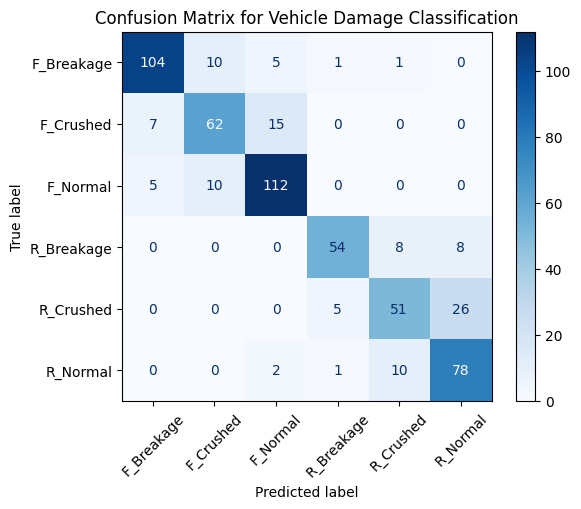

In [58]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

class_names = dataset.classes
num_classes = len(dataset.classes)

conf_matrix = confusion_matrix(labels, predictions, labels = np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Vehicle Damage Classification")
plt.show()

In [59]:
torch.save(model.state_dict(), 'save_model.pth')